In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

# Construction Zone: Building a Metropolis-Hastings Sampler From Scratch

#### Version 0.1

-----

By AA Miller (Northwestern/Adler Planetarium)

27 Aug 2019

As we just saw, Bayes' Law provides a framework for understanding/inferring model parameters *given* some observations/data:

$$P(\theta\mid\mathbf{x}) = \frac{P(\mathbf{x}\mid\theta)\;P(\theta)}{P(\mathbf{x})},$$

where we have used the short-hand notation with $\theta$ representing the model parameters, and $\mathbf{x}$ representing the data. 

To redefine some terms,

$P(\mathbf{x}\mid\theta)$, the probability of the data given the model parameters, is the *likelihood*, $\mathcal{L}$.

$P(\theta)$, the probability of the model parameters, is the *prior*.

$P(\mathbf{x})$ the probability of the data, is the *evidence*. (That sounds weird right? More on this in a bit...)

Finally, $P(\theta\mid\mathbf{x})$, the probability of the model parameters given the data, is the *posterior*. 

We typically want to estimate some model parameters, $\theta$, and thus we need to integrate the posterior, $P(\theta\mid\mathbf{x})$.

This is **hard**.

In particular, how in the world are we supposed to estimate the *probability of data*?!

This is –– capital H –– **Hard**.

(We will discuss this on Friday)

Fortunately, $P(\mathbf{x})$ simply serves as a normalization term, and, in many applications, can be ignored. 

Thus, given that the posterior is $\propto \mathcal{L}\;P(\theta)$, we can maximize the posterior by maximizing the product of the likelihood and the prior. While this still leaves a complicated integral, there are many tools that can approximate that integral rather efficiently...

including the Metropolis-Hastings algorithm!

## Problem 1) Simulate the Observations

As we work towards implementing the MH sampler, we will attempt to solve a very common problem in the statistical literature: estimating the slope and intercept of a line from noisy data.

Here we will simulate some data with known model parameters so we can later compare our estimates to the correct answer.

**Problem 1a**

Draw 40 observations between 0 and 100 from a linear model with slope, $m = 2.3$, and intercept, $b = 15$. Assume that each observation is drawn from a Gaussian distribution with mean $\mu = 0$ and variance, $\sigma^2$ = 2500.

In [17]:
np.random.seed(212)
m_true = 2.3
b_true = 15
x = np.random.uniform(low=0, high=100, size=40)
y_true = b_true + m_true*x
y_obs = y_true + np.random.normal(0,50,size=40)
y_unc = np.ones_like(y_obs)*50

**Problem 1b**

Plot the observations and the corresponding uncertainties. Overplot a line showing the model from which the data were drawn.

<IPython.core.display.Javascript object>


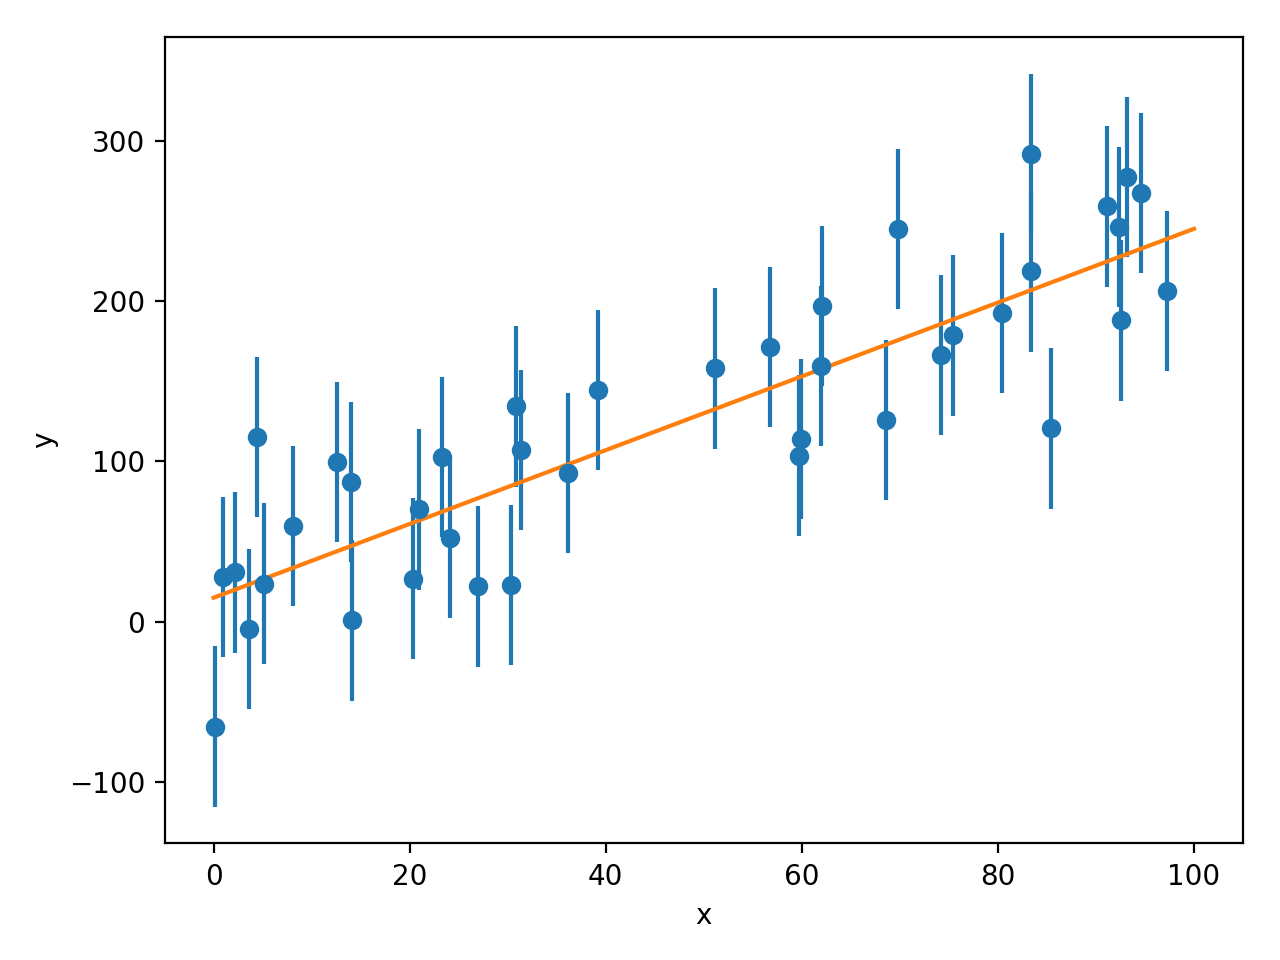

In [135]:
fig, ax = plt.subplots()

ax.errorbar(x, y_obs, y_unc, fmt='o')
ax.plot([0,100], b_true + m_true*np.array([0,100]))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

**Problem 1c**

Create a function `get_model_predictions` that calculates the expected value of $\mathbf{y}$ given input parameters `theta` and positions $\mathbf{x}$.

*Hint* - store the model parameters in a tuple `theta` = (m, b). This will make life easier later.

In [21]:
def get_model_predictions(theta, x):
    '''
    Calculate the model at any position x
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    Returns
    -------
    model_preds : arr-like, shape (n_samples)
        Array of model values
    '''
    m, b = theta
    model_preds = m*x + b
    
    return model_preds

## Problem 2) The Posterior

In order to approximate the posterior we need to be able to calculate it at any point within the multidimensional parameter space. 

Assuming gaussian distributed scatter in the observations, we can describe the probability of any individual observation as a function of the model parameters:

$$p(y_i \mid m, b, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}},$$

where $y_i$ is the $i^\mathrm{th}$ observation, $x_i$ is the corresponding indpendent position at which $y_i$ is measured, $\sigma_{y_i}$ is the uncertainty on $y_i$ (constant in this case, but that doesn't have to be the case), and $m$ and $b$ are the slope and intercept for  the line.

Assuming the observations are independent, then the probability of *all* the observations is the product of the individual probabilities (note –– this is the likelihood):

$$\mathcal{L} = \prod_i p(y_i \mid m, b, x_i, \sigma_i) = \prod_i \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}}.$$

This product produces really small numbers (individual observations have typical probabilities  < 0.3), which can become numerically unstable, especially for a poor choice of model parameters. 

A trick to alleviate this issue is to work with the $\log \mathcal{L}$, which using a logarithmic identity allows us to trade a product for a sum (computationally much easier!):

$$\log \mathcal{L} = \mathcal{K} - \sum_i \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2},$$

where $\mathcal{K}$ is a constant equal to $-\frac{n}{2}\log{2\pi} - \sum_i \log{\sigma_{y_i}}$.

Mathematically, maximizing the likelihood and the log likelihood are identical, and we will leverage this for the remainder of the problem.

**Problem 2a**

Write a function `lnlikelihood` to calculate the log likelihood given input parameters `theta`, `y`, `x`, and `y_unc`.

*Hint 1* –– the constant $\mathcal{K}$ is the same for any point in the parameter space. Thus it can be ignored as we only care about *relative* differences in the likelihood.

*Hint 2* –– store the model parameters in a single tuple `theta` = (m, b). This will make life easier later.

In [22]:
def lnlikelihood(theta, y, x, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

**Problem 2b**

Confirm your function works by estimating the log likelihood for $m = 1.5$ and $b = 50$.

Is the log likelihood higher or lower if you use the true model parameters (see **1a**)? 

Does this make sense?

In [29]:
print('ln L for m=1.5 and b=50 is: {:.4f}'.format(lnlikelihood((1.5,50), y_obs, x, y_unc)))
print('ln L for m=2.3 and b=15 is: {:.4f}'.format(lnlikelihood((2.3,15), y_obs, x, y_unc)))

ln L for m=1.5 and b=10 is: -20.7939
ln L for m=2.3 and b=15 is: -14.9359


*write your answer here*

While a slope of 1.5 and intercept of 50 appears to agree with the majority of the observations, it is clear that the true model values provide a higher value of the likelihood.

The posterior requires an estimate of not just the likelihood, but also the prior. 

For this problem, how in the world do we choose the prior? 

(In practice, this can be very complicated and we will discuss this in more detail on Wednesday and Friday)

When you have little to no knowledge of the actual model parameters, it is often "safe" to assume a wide and flat prior (sometimes referred to as an uniformative prior). A wide and flat prior essentially says that any value within the bounds of the prior is equally likely, while values outside the bounds are unacceptable. 

While we know the true answer, let's pretend that we don't. From the data (technically, using the data to estimate the prior is cheating, as we'll discuss on Friday) we can see that the slope is definitely positive, and also definitely less than 300 (the largest y value in the data set). Thus, we will set a uniform prior on $m$ from 0 to 300:

$$P(m) \sim \mathcal{U}(0,300).$$

From similar arguments the intercept is likely somewhere between -100 and 100:

$$P(b) \sim \mathcal{U}(-100,100).$$


**Problem 2c**

Write a function `lnprior` to calculate the log of the prior from an input tuple of the model parameters `theta`.

*Hint* - while the $\log{0}$ is undefined, have the function return `-np.inf` for values outside the bounds of the prior.

In [30]:
def lnprior(theta):
    '''
    Calculate the log of the prior for the model parameters
    
    Parameters
    ----------
    theta : tuple
        Model parameters
            
    Returns
    -------
    lnp : float
        The log-prior of the model parameters
    '''
    m, b = theta
    if 0 <= m <= 300 and -100 <= b <= 100:
        lnp = np.log(1/300) + np.log(1/200) # assumes P(m) and P(y) are completely independent
    else:
        return -np.inf
    
    return lnp

**Problem 2d**

Calculate the prior for $(m, b) = (1, 0)$, $(2.3, 15)$, $(3, -150)$, and $(-1, 90)$.

Do your answers make sense?

In [32]:
print('ln P for m=1.0 and b=0 is: {:.4f}'.format(lnprior((1.5,50))))
print('ln P for m=2.3 and b=15 is: {:.4f}'.format(lnprior((2.3,15))))
print('ln P for m=3 and b=-150 is: {:.4f}'.format(lnprior((3,-150))))
print('ln P for m=-1 and b=90 is: {:.4f}'.format(lnprior((-1,90))))

ln P for m=1.0 and b=0 is: -11.0021
ln P for m=2.3 and b=15 is: -11.0021
ln P for m=3 and b=-150 is: -inf
ln P for m=-1 and b=90 is: -inf


*write your answer here*

These answers to make sense. For model parameters within the bounds of the prior all values are equally likely, whereas there is no probability for model parameters outside the bounds of the model.

**Problem 2e**

Write a function `lnposterior` to calculate the log of the posterior.

*Hint* - this is straightforward using functions you have already written.

In [33]:
def lnposterior(theta, y, x, y_unc):
    '''
    Calculate the log posterior
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnpost : float
        The log-posterior from the observations and model parameters
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc)
    lnpost = lnl + lnp
        
    return lnpost

**Problem 2f**

What is the log posterior for $m = 1.5$ and $b = 50$?

What is the log posterior for $m = 2.3$ and $b = 15$?

What is the log posterior for $m = 1.5$ and $b = 200$?

Does this make sense?

In [34]:
print('ln posterior for m=1.5 and b=50 is: {:.4f}'.format(lnposterior((1.5,50), y_obs, x, y_unc)))
print('ln posterior for m=2.3 and b=15 is: {:.4f}'.format(lnposterior((2.3,15), y_obs, x, y_unc)))
print('ln posterior for m=1.5 and b=200 is: {:.4f}'.format(lnposterior((1.5,200), y_obs, x, y_unc)))


ln posterior for m=1.5 and b=50 is: -31.7960
ln posterior for m=2.3 and b=15 is: -25.9380
ln posterior for m=1.5 and b=200 is: -inf


*write your answer here*

These answers make sense. There is no probability outside the prior, and the posterior values are lower than the likelihood values.

## Problem 3) The Metropolis-Hastings Algorithm

The [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) (MH) is the most simple [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) procedure for estimating Bayesian posteriors. 

We will cover the nitty gritty (i.e., mathematics) of how MCMC works tomorrow. For now, we will focus on Metropolis-Hastings as an algorithm, and assume it works.  

The pseudo-code for the MH algorithm is:

0. pick some position $\theta_0$ in the parameter space and calculate the posterior $P(\theta_{0}\mid \mathbf{x})$
1. begin the chain
    - "propose" a move from the current position $\theta_{i}$ to a new position $\theta_{i+1}$
    - calculate the posterior at $\theta_{i+1}$, $P(\theta_{i+1}\mid \mathbf{x})$
    - draw a random number, $R \sim \mathcal{U}(0,1)$
    - if the ratio $P(\theta_{i+1}\mid \mathbf{x})/P(\theta_{i}\mid \mathbf{x})$ is $> R$, "accept" the proposed move and advance the chain to $\theta_{i+1}$
    - else "reject" the proposal and set $\theta_{i+1} = \theta_{i}$

2. repeat until chain is "finished"

A few subtleties worth noting: the use of the random number is essential for allowing the MH algorithm to "explore" the full posterior. It's actually possible to add links to the chain that are less probable than the current position. This is an important distinction relative to optimization routines that simply identify local maxima, but only progressing in the direction of increased probability.

Also "finished" isn't really defined - we will cover this tomorrow.

An extra subtle point: technically you need to calculate the full Hastings ratio, $H$, when evaluating whether or not to accept or reject a proposal:

$$H = \frac{\pi(\theta_{i+1})}{\pi(\theta_{i})} \frac{q(\theta_i \mid \theta_{i+1})}{q(\theta_{i+1} \mid \theta_{i})},$$

where $q(\theta_i \mid \theta_{i+1})/q(\theta_{i+1} \mid \theta_{i})$ is the ratio of transition probabilities from $\theta_{i+1}$ to $\theta_{i}$ and back again. 

Fortunately, most proposals are symmetric, including what we will implement, meaning the ratio of transition probabilities is 1, and thus, this term can be safely ignored.

**Problem 3a**

Write a function `hastings_ratio` to calculate the ratio of log-posterior values at `theta_1` relative to `theta_0`.

*Hint* –– assume the ratio of transition probabilities is 1.

In [40]:
def hastings_ratio(theta_1, theta_0, y, x, y_unc):
    '''
    Calculate the Hastings ratio
    
    Parameters
    ----------
    theta_1 : tuple
        proposed new posterior position 
    
    theta_0 : tuple
        current posterior position
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    h_ratio : float
        The Hastings ratio
    '''
    lnpost1 = lnposterior(theta_1, y_obs, x, y_unc)
    lnpost0 = lnposterior(theta_0, y_obs, x, y_unc)
    
    h_ratio = np.exp(lnpost1)/np.exp(lnpost0)
    
    return h_ratio

**Problem 3b**

Calculate the Hastings ratio to move from $(2.1, 50)$ to $(2.2,30)$.

How often would the algorithm accept this step?

In [43]:
print('The Hastings ratio is: {:.4f}'.format(hastings_ratio((2.2, 30), (2.1, 50), y_obs, x, y_unc)))

The Hastings ratio is: 55.7871


*write your answer here*

In this case is $H > 1$, and thus this proposed move  would be accepted every time.

**Problem 3c** 

What about the reverse proposal? Calculate the Hastings ratio to move from (2.2, 30) to (2.1, 50). 

On average, how many times would such a proposal need to be made to be accepted by the MH algortihm?

In [44]:
print('The Hastings ratio is: {:.4f}'.format(hastings_ratio( (2.1, 50), (2.2, 30), y_obs, x, y_unc)))

The Hastings ratio is: 0.0179


*write your answer here*

In this case is $H < 1$, and thus for this proposed move to be accepted we need $R < 0.0179$. This will occur, on average, about once every 56 proposals.

As we will show below, the difference between an MCMC chain that takes forever and one that samples the posterior "quickly" is largely a function of the proposal distribution. 

We want a symmetric proposal to ensure the transition ratio is equal to 1. The easiest way to accomplish this is with a normal distribution centered at the current position in the posterior, with a user-defined covariance matrix. (Today we will assume the covariance matrix is  diagonal).

**Problem 3d**

Write a function `propose_jump` that creates new proposal positions for the MCMC chain, based on its current position, `theta`, and a covariance matrix, `cov`, for the multivariate normal distribution centered on `theta`.

*Hint 1* - allow `cov` to be either 1-D with standard deviations as the input, in which case the entries are converted to a diagonal matrix, or 2-D, where the full covariance matrix is specified.

*Hint 2* - you may find [`numpy.random.multivariate_normal`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.multivariate_normal.html) helpful.

In [80]:
def propose_jump(theta, cov):
    '''
    Generate a proposed new position for MCMC chain
    
    Parameters
    ----------
    theta : 1-D array_like, of length N
        current position of the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    
    Returns
    -------
    proposed_position : 1-D array_like, of length N
    '''
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov)
    
    return proposed_position

**Problem 3e**

Propose 5 random steps from the position $(m, b) = (2, 45)$, and calculate the Hastings ratio for each of the 5 proposals. Use a standard deviation of 1 along both axes of the multivariate normal distribution.

Do you notice anything interesting about your results?

In [85]:
theta_0 = (2,45)
for _ in range(5):
    new_pos = propose_jump(theta_0, (1,1))
    H = hastings_ratio(new_pos, theta_0, y_obs, x, y_unc)
    print('Jumping to {}, gives H = {:.4f}'.format(new_pos, H))

Jumping to [ 3.60889739 44.28222739], gives H = 0.0000
Jumping to [ 3.54586493 46.33162347], gives H = 0.0000
Jumping to [ 1.75744589 44.23391524], gives H = 0.6521
Jumping to [ 2.47267529 44.665913  ], gives H = 0.0004
Jumping to [ 3.00215815 44.83050251], gives H = 0.0000


*write your answer here*

The Hastings ratios are all very small in this case. This is happening because the variance along the slope axis for the normal distribution is really large. 

**Problem 3f**

Repeat **3e** but this time use a standard deviation of 0.1 for the slope and 10 for intercept.

Are the results substantially different?

In [93]:
theta_0 = (2,45)
for _ in range(5):
    new_pos = propose_jump(theta_0, (0.1,10))
    H = hastings_ratio(new_pos, theta_0, y_obs, x, y_unc)
    print('Jumping to {}, gives H = {:.4f}'.format(new_pos, H))

Jumping to [ 1.98362468 45.46091553], gives H = 0.9738
Jumping to [ 2.02478078 43.1135773 ], gives H = 1.3194
Jumping to [ 2.01433903 29.51095665], gives H = 4.2514
Jumping to [ 1.95540873 45.29484195], gives H = 1.1007
Jumping to [ 1.90890834 33.04442042], gives H = 2.1250


*write your answer here*

The Hastings ratios are now much larger. It is clear that the width of the multivariate normal along each axis will affect the efficiency of the MH sampler.

Referring back to the pseudo code above, we now have all the ingredients necessary to put together a MH sampler. We just need to stitch everything together so that we actually form a chain.

**Problem 3g**

Write a function `mh_mcmc` that takes an initial position `theta_0`, covariance matrix for the multivariate normal proposal distribution `cov`, total number of steps `nsteps`, and observations `y`, `x`, and `y_unc` as inputs and returns the Metropolis-Hastings chain for the given inputs.

The output "chain" should include the position of the chain within the parameter space, the log of the posterior at that position, and the "acceptance ratio" of the chain until that point. The acceptance ratio is the fraction of previously proposed steps (including the current proposal) that have been accepted. We will come back to this later.

In [115]:
def mh_mcmc(theta_0, cov, nsteps, y, x, y_unc):
    '''
    Metropolis-Hastings MCMC algorithm
    
    Parameters
    ----------
    theta_0 : 1-D array_like of shape N
        starting position for the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    nsteps : int
        Number of steps to take in the MCMC chain
        
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    (positions, lnpost_at_pos, acceptance_ratio) : tuple
        positions : 2-D array_like of shape (nsteps+1, N)
            Position of the MCMC chain at every step
        
        lnpost_at_pos : 1-D array_like of shape nsteps+1
            log-posterior value at the position of the MCMC chain
        
        acceptance_ratio : 1-D array_like of shape nsteps+1
            acceptance ratio of all previous steps in the chain    
    '''
    
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0
    
    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y, x, y_unc)
    
    for step_num in np.arange(1, nsteps+1):
        proposal = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(proposal, positions[step_num-1], y, x, y_unc)
        R = np.random.uniform()
        
        if H > R:
            accepted += 1
            positions[step_num] = proposal
            lnpost_at_pos[step_num] = lnposterior(proposal, y, x, y_unc)
            acceptance_ratio[step_num] = float(accepted)/step_num
        else:
            positions[step_num] = positions[step_num-1]
            lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
            acceptance_ratio[step_num] = float(accepted)/step_num
    
    return (positions, lnpost_at_pos, acceptance_ratio)

**Problem 3h**

Run the MH sampler! 

Using a starting point of $(m, b) = (2.7, -70)$ (this is estimated from the two most extreme points in the dataset), `cov = (0.25, 5)`, and run the chain for 500 steps.

In [136]:
pos, lnpost, acc = mh_mcmc((2.7,-70), (0.25, 5), 500, y_obs, x, y_unc)

**Problem 3i**

Plot the positions of the chain in the $(m, b)$ plane. Overplot the true answer as a five-pointed star.

Does your plot "make sense"?

*Hint* –– connect the points with line segments so you can visualize its evolution. 

*Hint 2* –– set `alpha = 0.4` to get a sense of positions where multiple proposals were required for the chain to move.

<IPython.core.display.Javascript object>


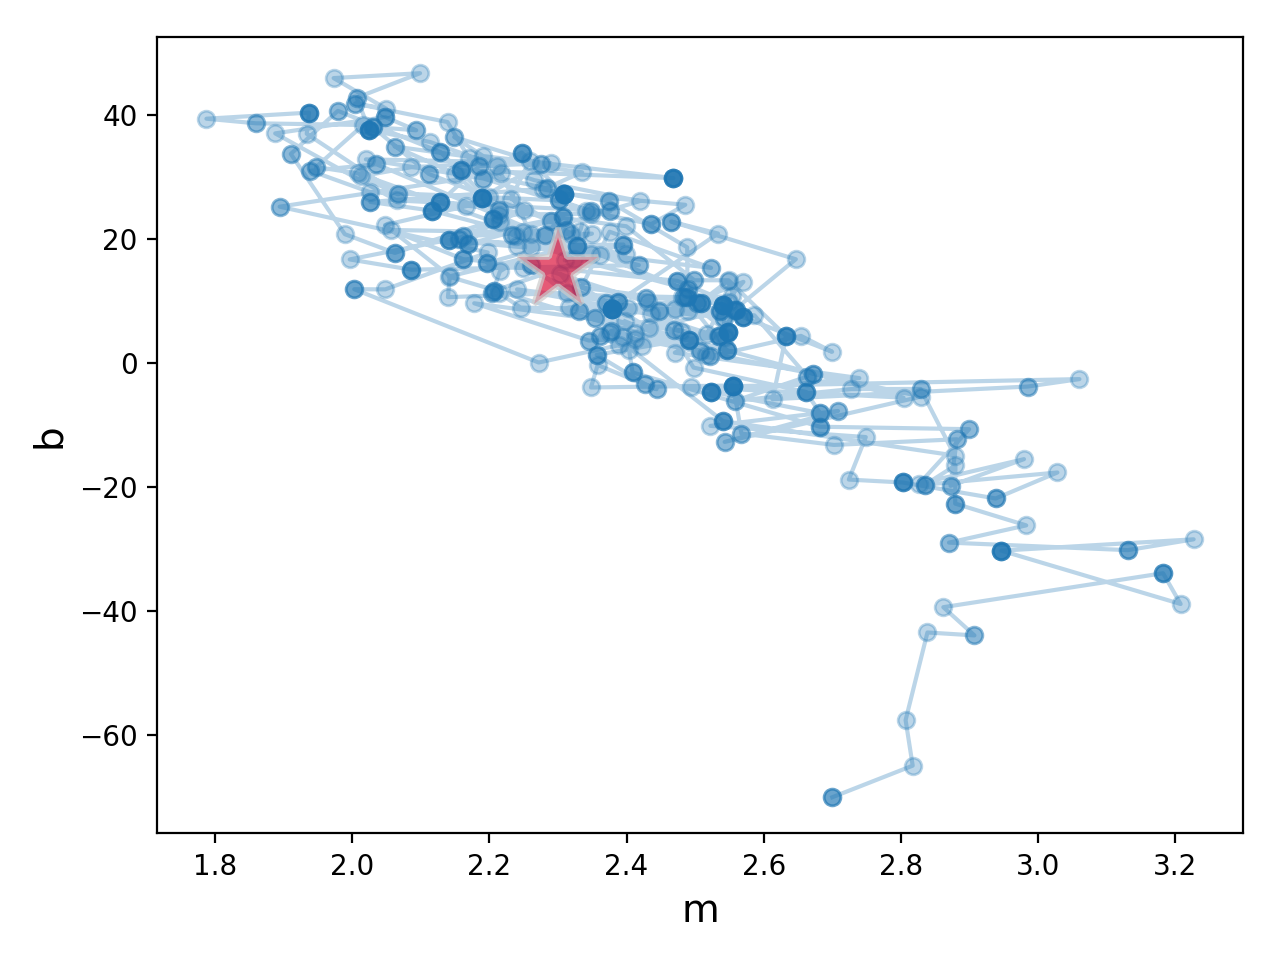

In [146]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1], 'o-', alpha=0.3)
ax.plot(2.3, 15, '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('b', fontsize=14)
fig.tight_layout()

**Problem 3j**

Recreate the above plot, but this time color code the individual points by the value of the log posterior at each position.

*Hint* –– you will want to use [`pyplot.scatter`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html)

<IPython.core.display.Javascript object>


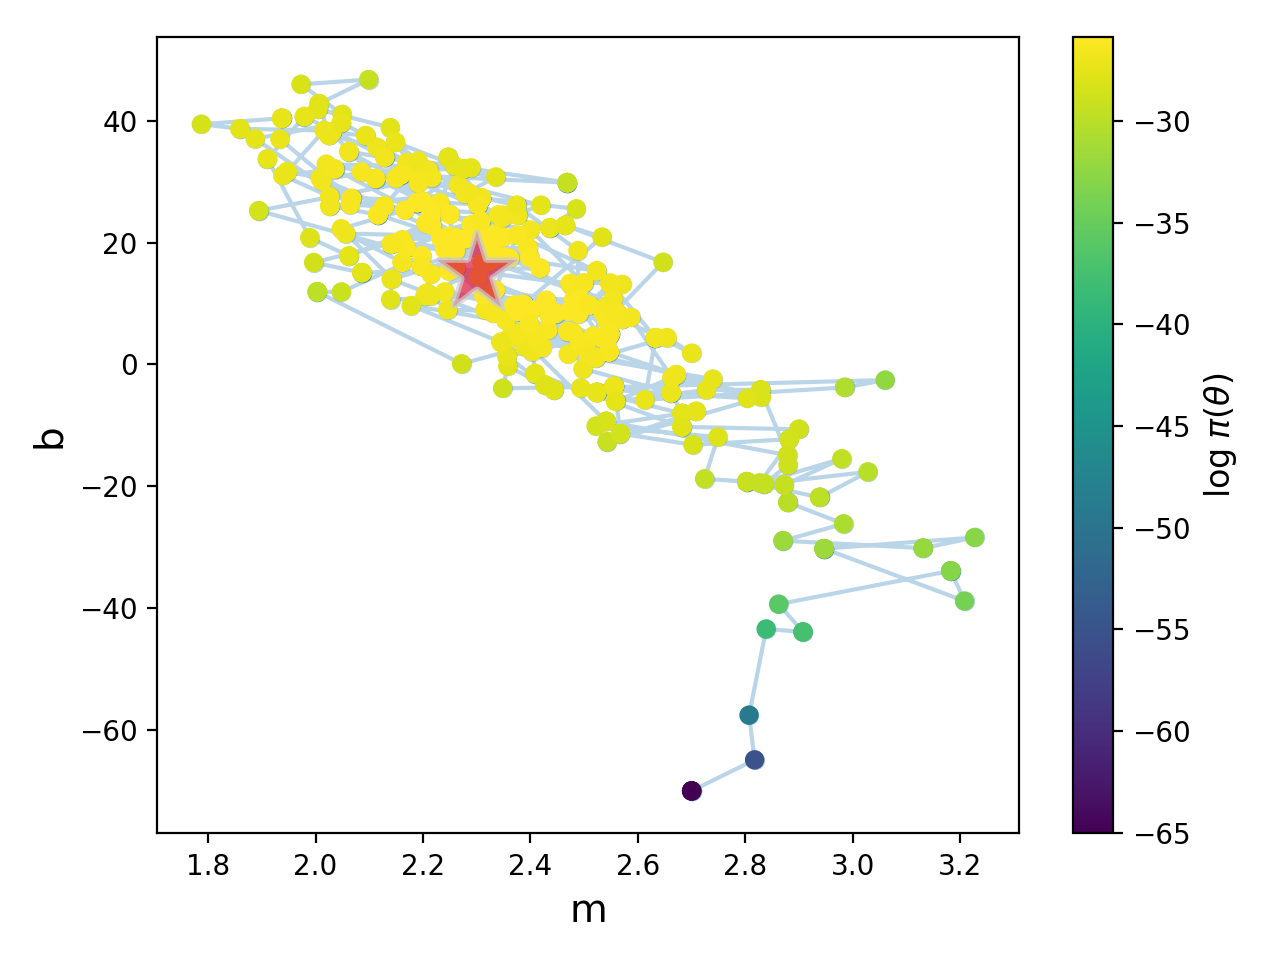

In [157]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1], 'o-', alpha=0.3)
cax = ax.scatter(pos[:,0], pos[:,1], c = lnpost, zorder=10)
ax.plot(2.3, 15, '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7, zorder=20)
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('b', fontsize=14)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(r'$\log \; \pi (\theta)$', fontsize=12)
fig.tight_layout()

Awesome! 

You are now tooled up to solve any Bayesian problem that you might encounter.

## Problem 4) Optimizing MH

While you are now, no doubt, wildly excited about what you have accomplished in $\sim{90}$ min time, there should be a few things that bother you. In particular, there were several "hard coded" options in the previous problem. 

#### Weird Choice #1

Why 500 steps? 

It's clear from **3i** that ~10-20 steps is no where near enough, as the chain does not sample the maximum of the posterior. But is 500 steps too many? Or is it not enough?

(There are mathematical ways to judge this, which we will cover tomorrow)

#### Weird Choice #2

Why `(0.2, 10)` for the widths of the multivariate normal proposal function?

Previously we saw that 